Setting Up Initial Project Requirements

In [55]:
# Importing Necessary libraries
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt


In [56]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# Setting the path to your dataset
base_path = '/content/drive/My Drive/defect model/NEU Metal Surface Defects Data'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
valid_path = os.path.join(base_path, 'valid')


### **Exploratory Data Analysis**

Content

In [58]:
# Function to read and print the contents of a directory
def read_directory_contents(directory_path):
    print(f"Contents of {directory_path}:")
    for filename in os.listdir(directory_path):
        print(filename)

# Read and print contents of each directory
read_directory_contents(train_path)
read_directory_contents(test_path)
read_directory_contents(valid_path)


Contents of /content/drive/My Drive/defect model/NEU Metal Surface Defects Data/train:
Crazing
Inclusion
Patches
Pitted
Rolled
Scratches
Contents of /content/drive/My Drive/defect model/NEU Metal Surface Defects Data/test:
Crazing
Inclusion
Patches
Pitted
Rolled
Scratches
Contents of /content/drive/My Drive/defect model/NEU Metal Surface Defects Data/valid:
Crazing
Inclusion
Patches
Pitted
Rolled
Scratches


Class Distribution Evaluation

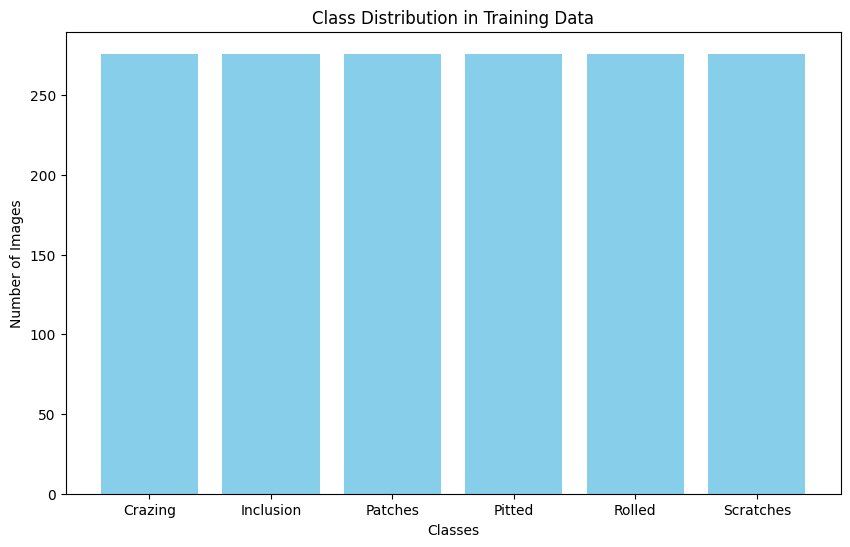

In [59]:

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, [len(os.listdir(os.path.join(train_path, class_folder))) for class_folder in classes], color='skyblue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()


The class distribution is balanced hence reducing biases on minority or dominant inclination, better generalization and interpretation of the evaluation metrics


Understanding the defect types from each class instance

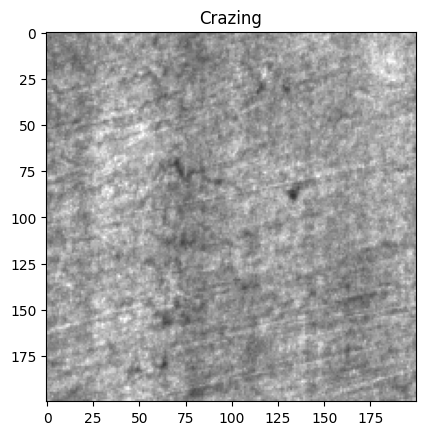

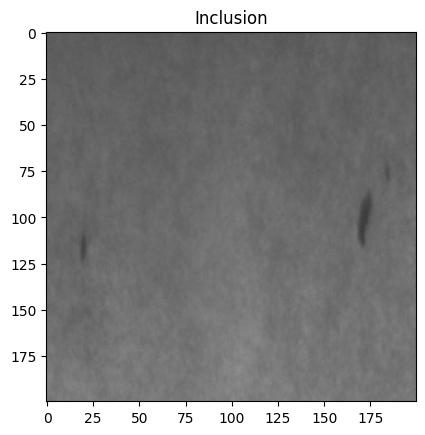

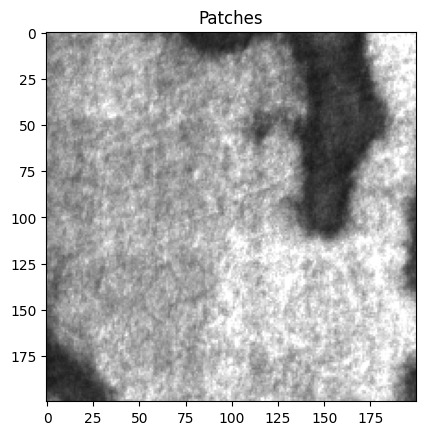

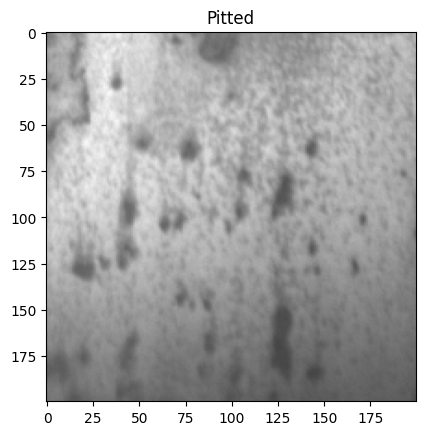

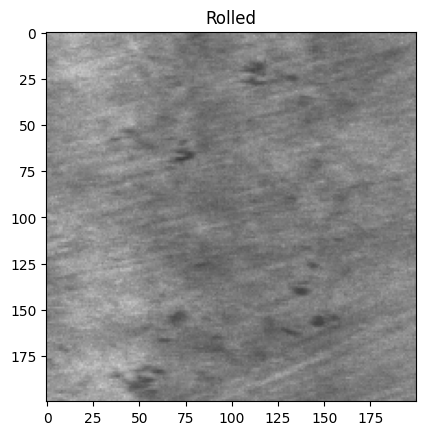

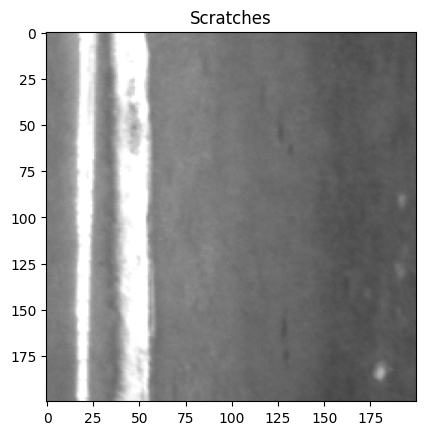

In [60]:

# Explore the dataset

def plot_images(class_folder):
    class_path = os.path.join(train_path, class_folder)
    img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(class_folder)
    plt.show()

# Plot an example image from each class
classes = os.listdir(train_path)
for class_folder in classes:
    plot_images(class_folder)

# Step 2.3: Preprocess the images

from keras.preprocessing.image import ImageDataGenerator





In [61]:
# Step 2.5: Explore Image Sizes

def explore_image_sizes(class_folder):
    class_path = os.path.join(train_path, class_folder)
    img_files = os.listdir(class_path)
    img_paths = [os.path.join(class_path, img_file) for img_file in img_files]

    # Display the sizes of the first few images in the class
    for img_path in img_paths[:5]:
        img = image.load_img(img_path)
        img_array = image.img_to_array(img)
        print(f"Image size for {class_folder}: {img_array.shape}")

# Explore image sizes for each class
for class_folder in classes:
    explore_image_sizes(class_folder)


Image size for Crazing: (200, 200, 3)
Image size for Crazing: (200, 200, 3)
Image size for Crazing: (200, 200, 3)
Image size for Crazing: (200, 200, 3)
Image size for Crazing: (200, 200, 3)
Image size for Inclusion: (200, 200, 3)
Image size for Inclusion: (200, 200, 3)
Image size for Inclusion: (200, 200, 3)
Image size for Inclusion: (200, 200, 3)
Image size for Inclusion: (200, 200, 3)
Image size for Patches: (200, 200, 3)
Image size for Patches: (200, 200, 3)
Image size for Patches: (200, 200, 3)
Image size for Patches: (200, 200, 3)
Image size for Patches: (200, 200, 3)
Image size for Pitted: (200, 200, 3)
Image size for Pitted: (200, 200, 3)
Image size for Pitted: (200, 200, 3)
Image size for Pitted: (200, 200, 3)
Image size for Pitted: (200, 200, 3)
Image size for Rolled: (200, 200, 3)
Image size for Rolled: (200, 200, 3)
Image size for Rolled: (200, 200, 3)
Image size for Rolled: (200, 200, 3)
Image size for Rolled: (200, 200, 3)
Image size for Scratches: (200, 200, 3)
Image size

## **Data Preprocessing**

Image Standardization and Pixel Normalization

We'll resize the images to a standard size of 150x150 pixels and normalize pixel values to a common scale.

This helps in evaluation efficiency

In [62]:
# Set image dimensions
img_width, img_height = 150, 150

# Modify the data generators to use 'categorical' class_mode
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'  # Change to 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'  # Change to 'categorical'
)
# Step 2.4: Prepare the dataset for training

# Number of training and validation samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)




Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


Augumentation



>

Augmentation introduces randomness during training to prevent overfitting.

In [63]:
# Step 2.4: Augmentation

train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Note: We do not augment the validation data
validation_datagen_augmented = ImageDataGenerator(rescale=1./255)


## **Feature Engineering**

In [74]:
# Step 3: Feature Extraction Using Multiple Pre-trained Models

from keras.applications import VGG16, MobileNetV2, InceptionV3
from keras.models import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

# Function to create and compile a model based on a pre-trained model
def create_model(base_model, class_activation='softmax'):
    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = Flatten()(x)

    # Add a dense layer for classification
    x = Dense(256, activation='relu')(x)
    predictions = Dense(len(classes), activation=class_activation)(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create models using MobileNetV2 and InceptionV3
mobilenet_model = create_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)))
inception_model = create_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)))

# print("\nMobileNetV2 Model Summary:")
# mobilenet_model.summary()


In [75]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## **Training the Models**

In [76]:
# Step 4: Training the Models

# Set the number of epochs
epochs = 3  # You can adjust this based on your computational resources and training progress


from keras.callbacks import EarlyStopping

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the MobileNetV2 model
history_mobilenet = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // 32,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // 32
)

# Train the InceptionV3 model
history_inception = inception_model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // 32,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // 32,
    callbacks=[early_stopping]
)



Epoch 1/3
51/51 [==============================] - 42s 729ms/step - loss: 3.0819 - accuracy: 0.8646 - val_loss: 4.1094e-05 - val_accuracy: 1.0000
Epoch 2/3
51/51 [==============================] - 32s 632ms/step - loss: 0.0386 - accuracy: 0.9914 - val_loss: 1.4171e-04 - val_accuracy: 1.0000
Epoch 3/3
51/51 [==============================] - 32s 632ms/step - loss: 0.0286 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 1/3
51/51 [==============================] - 84s 2s/step - loss: 0.2684 - accuracy: 0.9126 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 2/3
51/51 [==============================] - 74s 1s/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/3
51/51 [==============================] - 74s 1s/step - loss: 0.0680 - accuracy: 0.9901 - val_loss: 0.0025 - val_accuracy: 1.0000


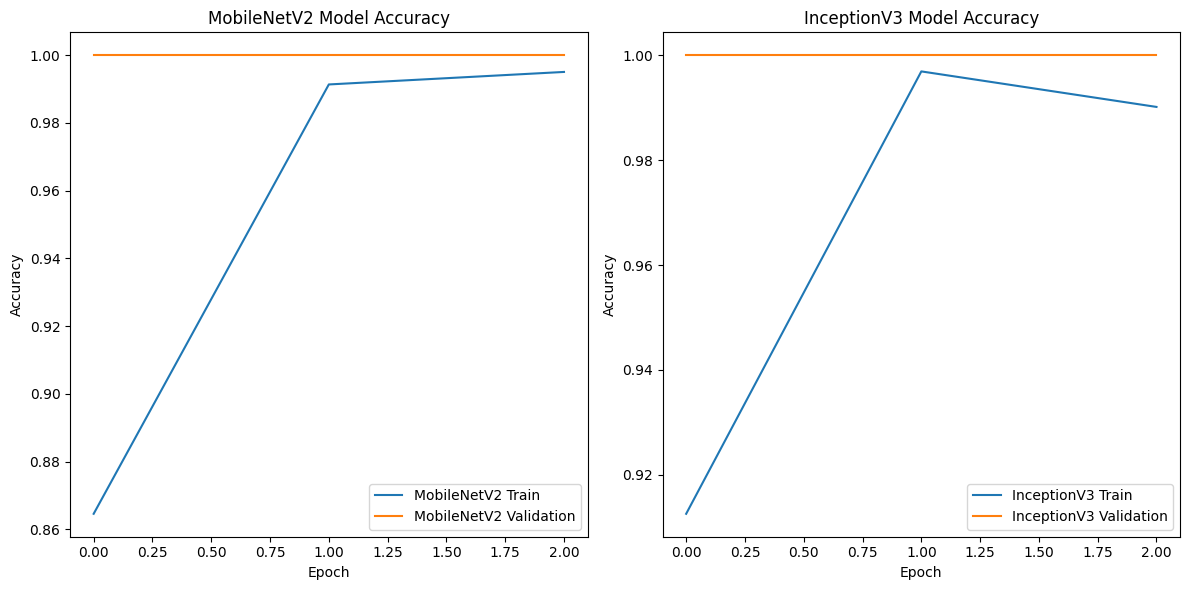

In [77]:
# Visualize training accuracy for MobileNetV2 and InceptionV3 comparatively

plt.figure(figsize=(12, 6))

# Plot training accuracy values for MobileNetV2
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 Train')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2 Validation')
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training accuracy values for InceptionV3
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['accuracy'], label='InceptionV3 Train')
plt.plot(history_inception.history['val_accuracy'], label='InceptionV3 Validation')
plt.title('InceptionV3 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


MobileNetV2 is performing better, and therefore we will rely on that

In [78]:
from joblib import dump

# Save the trained MobileNetV2 model to Google Drive
mobilenet_model.save('/content/drive/My Drive/defect model/mobilenet_model.h5')
